# What is Volcano Forecasting?
This is an introduction to understanding the data and the problem.

**Volcanoes are awesome!** both in the California way and the "instilling awe" way.

![Mount Etna CC-BY Kuhnmi Flickr](https://i.imgur.com/TZUE3ht.jpg)
Mount Etna on a calm day. (CC-BY Kuhnmi [Flickr](https://www.flickr.com/photos/31176607@N05/25720452925))

Volcano monitoring is important for both the inhabitants on and next to volcanoes, but also globally, as seen with the [Eyjafjallajökull eruption](https://en.wikipedia.org/wiki/2010_eruptions_of_Eyjafjallaj%C3%B6kull) disrupting air travel ten years ago. Geophysics is the field that largely works with active volcanoes and their activity, measuring earthquakes, tiltmeters, changes in gravimetry, etc. Specifically, seismologists record the rumble of the Earth when the magma forces its way upward. Geochemists collect data on degassing on Volcanos. And geologists are looking how the rocks form from lava. 

In the spirit of the competition, we should not find additional metadata, however, it's important to understand the kind of data we are dealing with. A Nature article ([Hall 2018](https://www.nature.com/articles/d41586-018-07420-y#ref-CR1)) describes the world's first automatic volcano forecast system on Mount Etna. The data for this is mostly of acoustic nature, specifically infrasound ([Ripepe et al. 2018](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2018JB015561)). Seeing that we have 10 sensors with timeseries, it's pretty safe to make the assumption that we are dealing with a seismological problem. These tend to be the most reliable, as compared to e.g. gas analyzers. Gas analyzers have to be right on top of a vent (which tend to rebuild in the lifetime of volcanoes), whereas the seismological stations just have to listen and not run out of battery.

So let's have a look at the actual data!

# Data
Files
train.csv Metadata for the train files.

`segment_id`: ID code for the data segment. Matches the name of the associated data file.

`time_to_eruption`: The target value, the time until the next eruption.

`[train|test]/*.csv`: the data files. Each file contains ten minutes of logs from ten different sensors arrayed around a volcano. The readings have been normalized within each segment, in part to ensure that the readings fall within the range of int16 values. If you are using the Pandas library you may find that you still need to load the data as float32 due to the presence of some nulls.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plots
import seaborn as sns

from pathlib import Path
from tqdm import tqdm

random_state = 42

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train.csv")
train.describe()

,segment_id,time_to_eruption
count,4.431000e+03,4.431000e+03
mean,1.074694e+09,2.284891e+07
std,6.161966e+08,1.348439e+07
min,5.131810e+05,6.250000e+03
25%,5.527934e+08,1.127016e+07
50%,1.066153e+09,2.246559e+07
75%,1.606350e+09,3.434356e+07
max,2.146939e+09,4.904609e+07


In [3]:
sequence = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/1000015382.csv", dtype="Int16")
sequence.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,59847.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,0.382244,2.266563,2.192213,-0.148031,-0.263129,1.630089,-0.615190,-0.177964,-0.402777,0.896752
std,111.553322,451.741111,373.923764,231.812464,129.504432,222.294642,269.678045,319.999406,176.087814,249.024286
min,-920.000000,-7871.000000,-2444.000000,-1815.000000,-2484.000000,-1128.000000,-1453.000000,-2947.000000,-1585.000000,-2961.000000
25%,-66.000000,-163.000000,-223.000000,-150.000000,-30.000000,-147.000000,-172.000000,-194.000000,-106.000000,-117.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67.000000,168.000000,224.000000,149.000000,30.000000,149.000000,174.000000,195.000000,106.000000,119.000000
max,822.000000,7321.000000,2563.000000,1491.000000,2608.000000,1119.000000,1668.000000,3676.000000,1162.000000,3179.000000


In [4]:
sequence.tail()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
59996,245,75,-306,307,-49,118,361,824,-25,371
59997,248,29,-398,145,-29,196,308,892,-38,408
59998,146,-100,-525,10,-5,344,217,837,-137,509
59999,86,-275,-619,-72,16,354,171,602,7,648
60000,103,-313,-648,-162,33,527,137,238,-40,695


Each sequence is 10 minutes long with 600001 samples. The data is `int16` but contains nan's, luckily with Pandas 1.0 they introduced the [nullable integer datatype](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html), just make sure to actually call it capitalized `"Int16"` so Pandas knows.

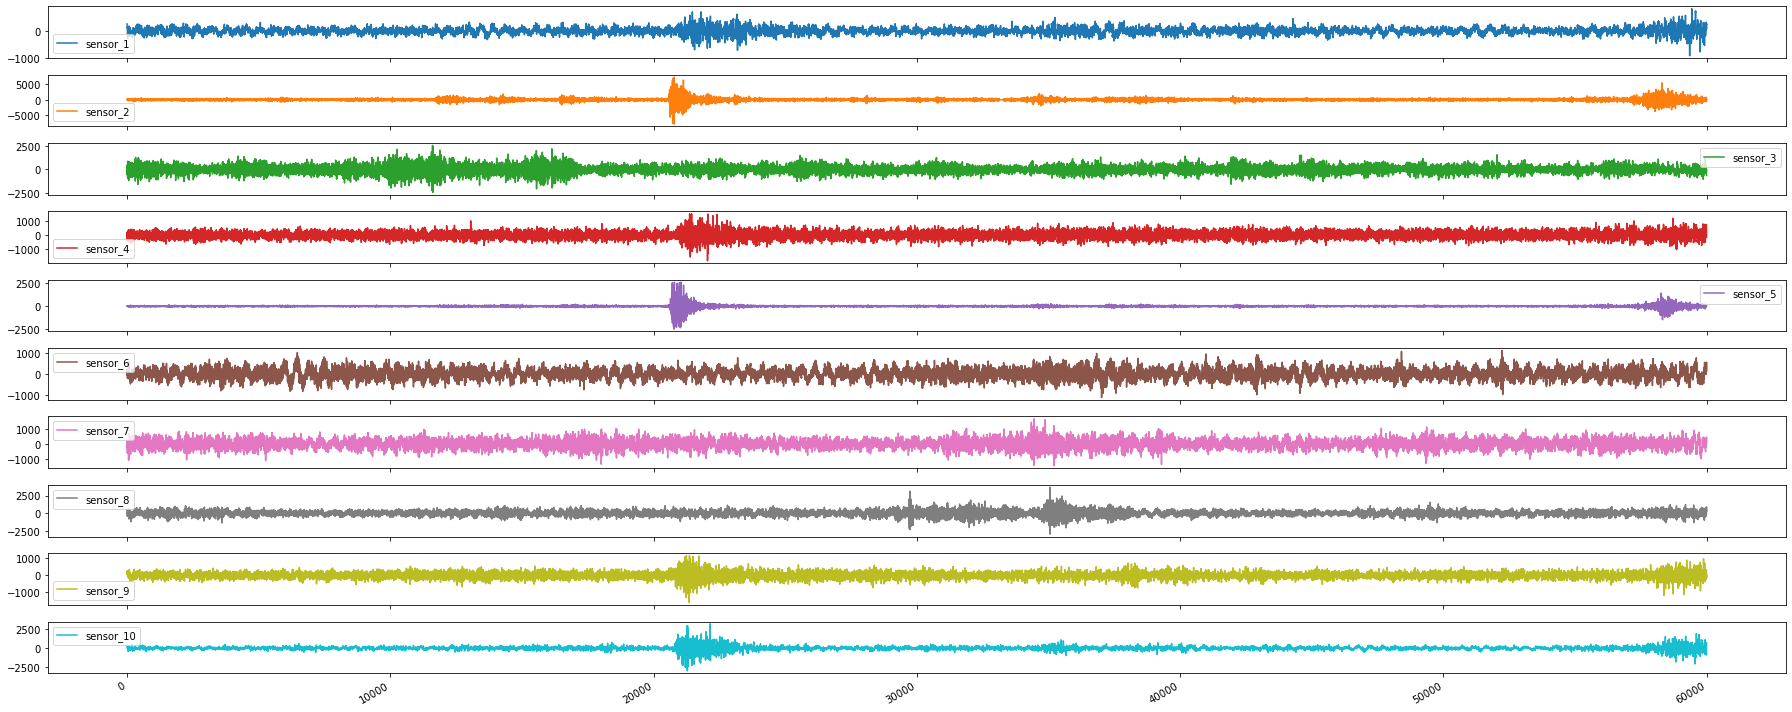

In [5]:
sequence.fillna(0).plot(subplots=True, figsize=(25, 10))
plt.tight_layout()
plt.show()

These stations clearly have similar data, but are shifted in time. Why?

Look at this digital elevation model from Etna from ([Bonaccorso 2011](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010GC003480))

![Bonaccorso 2011 DEM of Etna](https://i.imgur.com/2b99LHc.jpg)

The different stations are located all around the crater. That means the further away a station is from the magma or hypocentre of an Earthquake or other accoustic signals like streets, or [humans](https://www.weforum.org/agenda/2020/07/seismic-anthropogenic-noise-lockdown-covid19/), the longer the acoustic wave has to travel, arriving later at the station. So we can assume the with regards to that one signel event above, station 9 and 10 are almost identical in how far they are from it. Sensor 8 is a bit further.

Additionally, you can see the different noise levels of the data. Sensor 5 is fantastically quiet, only responding to big events, while Sensor 6 has some extremely periodic noise on it. It'd be worth to investigate if this is always the case.

Overall, the sensors will have different lags, depending where the volcanic activity is happening. So when we build a model that uses the time series, this is something to keep in mind.

# Play With the Data
Time series are hard. Can we get away with initially playing with some aggregate statistics?

In [6]:
def agg_stats(df, idx):
    df = df.agg(['sum', 'min', "mean", "std", "median", "skew", "kurtosis"])
    df_flat = df.stack()
    df_flat.index = df_flat.index.map('{0[1]}_{0[0]}'.format)
    df_out = df_flat.to_frame().T
    df_out["segment_id"] = int(idx)
    return df_out

In [7]:
summary_stats = pd.DataFrame()
for csv in tqdm(Path("../input/predict-volcanic-eruptions-ingv-oe/train/").glob("**/*.csv"), total=4501):
    df = pd.read_csv(csv)
    summary_stats = summary_stats.append(agg_stats(df, csv.stem))

 98%|█████████▊| 4431/4501 [10:51<00:10,  6.80it/s]


In [8]:
test_data = pd.DataFrame()
for csv in tqdm(Path("../input/predict-volcanic-eruptions-ingv-oe/test/").glob("**/*.csv"), total=4501):
    df = pd.read_csv(csv)
    test_data = test_data.append(agg_stats(df, csv.stem))

4520it [10:42,  7.03it/s]


In [9]:
features = list(summary_stats.drop(["segment_id"], axis=1).columns)
target_name = ["time_to_eruption"]
summary_stats = summary_stats.merge(train, on="segment_id")
summary_stats.head()

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,sensor_6_kurtosis,sensor_7_kurtosis,sensor_8_kurtosis,sensor_9_kurtosis,sensor_10_kurtosis,segment_id,time_to_eruption
0,-78411.0,-171885.0,-142998.0,126715.0,-60623.0,-156491.0,124731.0,78703.0,-22995.0,-818775.0,...,0.296273,0.251165,1.436491,0.374140,0.314539,0.784804,0.370370,0.508642,2037160701,30361976
1,-289512.0,-184486.0,123286.0,-32279.0,63999.0,-222697.0,66455.0,-150282.0,-57851.0,-62562.0,...,0.426041,0.681990,2.800551,0.389705,0.315683,0.056264,0.370289,0.857948,1238398453,14442539
2,0.0,-70416.0,0.0,132032.0,0.0,-728333.0,46405.0,-185634.0,-62648.0,2458.0,...,NaN,0.598462,NaN,64.659428,1.220101,-0.125872,1.760711,1.699990,1894979055,47567588
3,25313.0,-233527.0,-84557.0,23915.0,47809.0,1185917.0,-7192.0,-153198.0,29340.0,375454.0,...,0.371273,1.307610,2.417568,0.051997,1.516264,0.156257,2.017277,1.623933,621561921,44626195
4,82377.0,15980.0,103962.0,84736.0,111283.0,313298.0,12638.0,223843.0,-48540.0,-218824.0,...,0.019950,0.089579,1.930802,1.205281,0.019405,1.105820,0.236229,0.394681,310353509,24285029


In [10]:
summary_stats.describe()

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,sensor_6_kurtosis,sensor_7_kurtosis,sensor_8_kurtosis,sensor_9_kurtosis,sensor_10_kurtosis,segment_id,time_to_eruption
count,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,...,3996.000000,4431.000000,3836.000000,4431.000000,4389.000000,3991.000000,4307.000000,4407.000000,4.431000e+03,4.431000e+03
mean,-3.154637e+04,6.642264e+04,-7.115497e+04,-6.911549e+03,1.703888e+05,8.371901e+03,-9.131113e+03,-3.930828e+02,-6.063665e+03,-1.970177e+04,...,1.779537,2.409261,7.530025,1.393769,8.016503,4.359954,2.248869,2.614465,1.074694e+09,2.284891e+07
std,1.074697e+06,4.234405e+06,1.454592e+06,1.199746e+06,4.345850e+06,1.432993e+06,1.206980e+06,1.390008e+06,1.227877e+06,2.005872e+06,...,10.429411,7.861910,15.242927,12.582408,284.562984,22.386326,7.854015,8.776947,6.161966e+08,1.348439e+07
min,-3.572893e+07,-1.471348e+07,-3.467549e+07,-2.729633e+07,-6.630852e+06,-4.027425e+07,-4.723766e+07,-5.815644e+07,-2.519325e+07,-6.419481e+07,...,-1.163593,-0.869809,-0.936414,-1.443972,-0.861134,-1.078357,-0.876845,-1.402664,5.131810e+05,6.250000e+03
25%,-1.072995e+05,-8.585300e+04,-1.087195e+05,-9.845400e+04,-2.699850e+04,-1.762360e+05,-1.396805e+05,-1.101665e+05,-8.263250e+04,-1.987590e+05,...,0.174041,0.220774,0.843226,-0.063266,0.243225,0.036524,0.256607,0.304380,5.527934e+08,1.127016e+07
50%,1.062000e+03,0.000000e+00,0.000000e+00,-1.022000e+03,0.000000e+00,1.836000e+03,7.731000e+03,0.000000e+00,0.000000e+00,5.861000e+03,...,0.426267,0.574138,2.154965,0.073785,0.764163,0.273745,0.669426,0.795795,1.066153e+09,2.246559e+07
75%,1.095300e+05,8.361850e+04,8.270450e+04,9.850450e+04,2.645550e+04,1.744185e+05,1.313650e+05,1.173110e+05,8.784450e+04,2.270125e+05,...,1.183498,1.757019,6.659629,0.316384,2.580724,1.401245,1.803676,2.358021,1.606350e+09,3.434356e+07
max,2.047363e+07,2.687404e+08,3.331265e+07,3.894129e+07,1.799850e+08,5.094290e+07,2.035339e+07,4.406151e+07,4.512942e+07,6.134024e+07,...,448.313264,163.849752,195.422373,414.113602,18806.195641,676.327801,264.051749,234.337549,2.146939e+09,4.904609e+07


# Train a LightGBM Regressor

Use [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html), because if you don't [shakeup](https://www.kaggle.com/jtrotman/meta-kaggle-competition-shake-up) will not be your friend.

In [11]:
import lightgbm as lgbm
from sklearn.model_selection import KFold
import gc


n_fold = 7
folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)

data = summary_stats

params = {
    "n_estimators": 2000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": random_state,
    "nthread": -1,
    "device": "gpu",
}

sub_preds = np.zeros(test_data.shape[0])
feature_importance = pd.DataFrame(index=list(range(n_fold)), columns=features)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[features].iloc[trn_idx], data[target_name].iloc[trn_idx]
    val_x, val_y = data[features].iloc[val_idx], data[target_name].iloc[val_idx]
    
    model = lgbm.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=0, early_stopping_rounds=150
           )

    feature_importance.iloc[n_fold, :] = model.feature_importances_
    
    sub_preds += model.predict(test_data[features], num_iteration=model.best_iteration_) / folds.n_splits


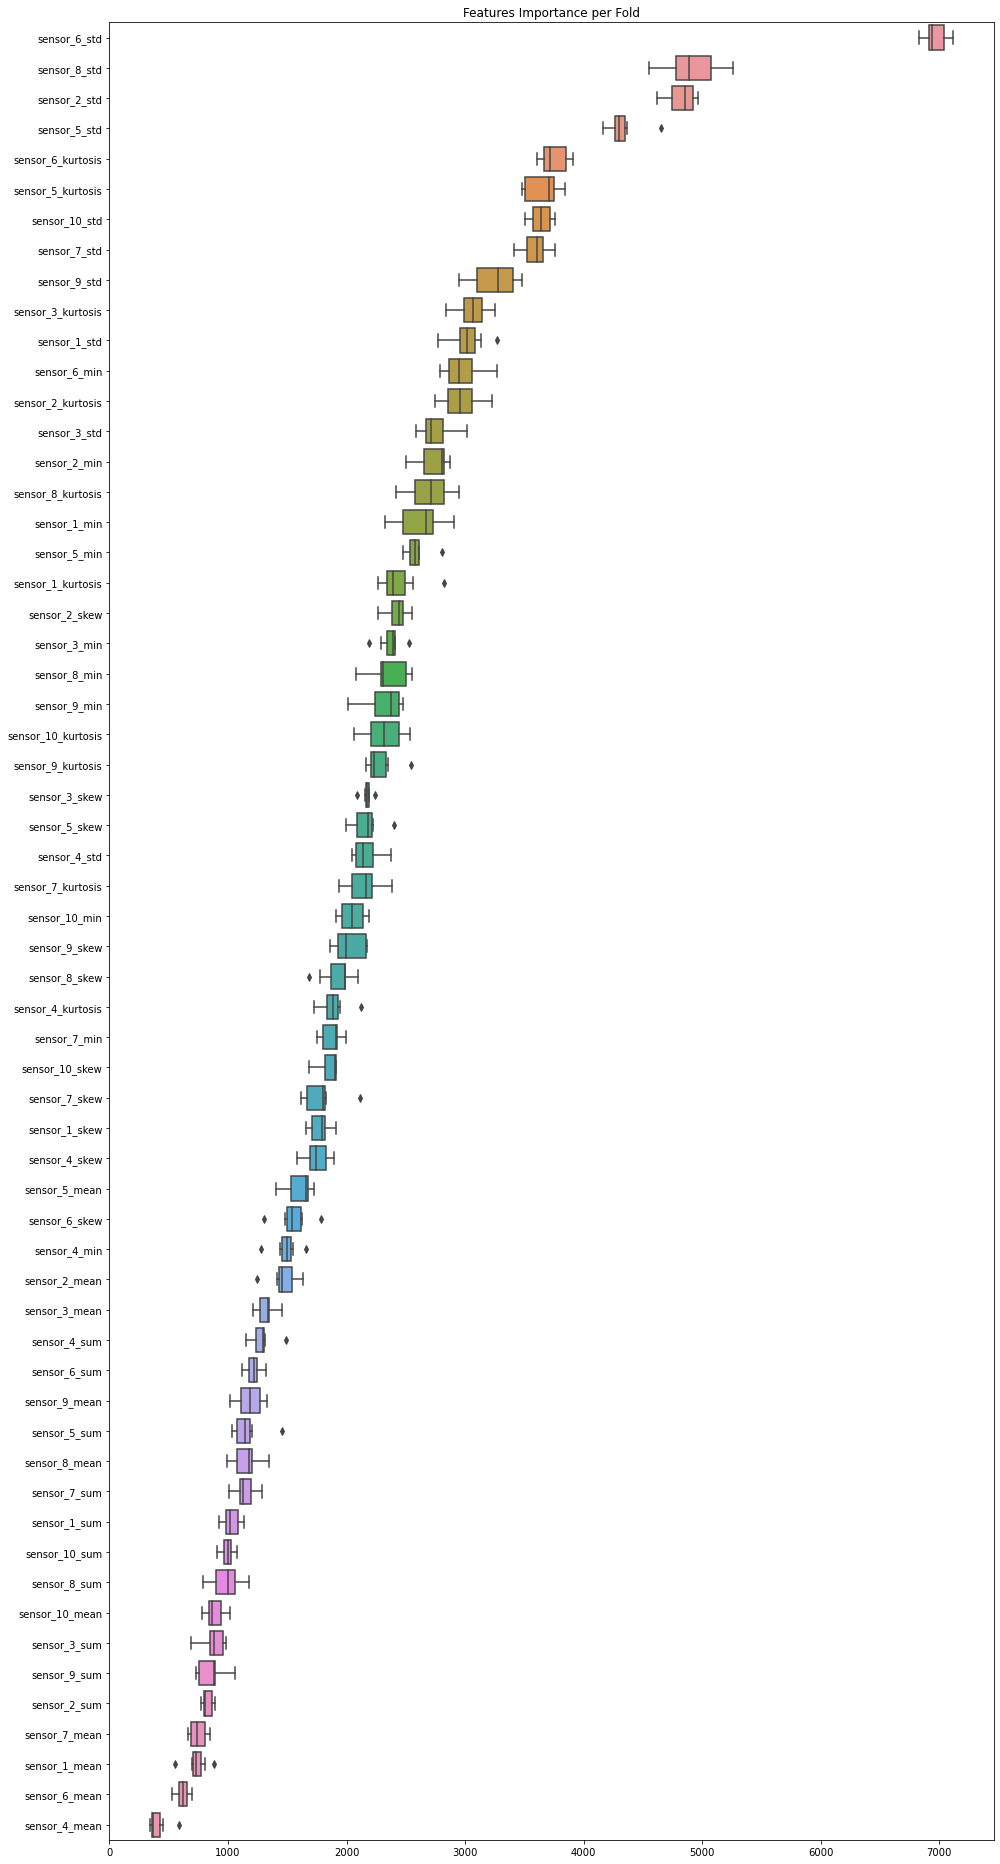

In [12]:
best = feature_importance.mean().sort_values(ascending=False)
best_idx = best[best > 5].index

plt.figure(figsize=(14,26))
sns.boxplot(data=feature_importance[best_idx], orient="h")
plt.title("Features Importance per Fold")
plt.tight_layout()

So that gives us a nice idea which data actually matters for the next iteration.

# Submit Prediction
Let's build a csv for submission.

In [13]:
submission = pd.DataFrame()
submission['segment_id'] = test_data["segment_id"]
submission['time_to_eruption'] = sub_preds
submission.to_csv('submission.csv', header=True, index=False)

# How Far Can One Go?
Need Inspiration?

Of course someone tried Transformers on Earthquake time series, to detect the event and different phases. I love multi tasking like that!
![Nature Paper on Earthquake Transformers](https://i.imgur.com/KvRcjLh.png)
Seismogram tagging on full sequences with an Earthquake Transformer in Nature ([Mousavi 2020](https://www.nature.com/articles/s41467-020-17591-w)).